In [84]:
from PIL import Image
import torch
import torch as th
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize, ToTensor)
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
imagePath = 'tiger.jpg'

In [15]:
def computeGradient(func, inp, **kwargs):
    inp.requires_grad = True
    try:
        inp.grad.zero_()
    except:
        pass
    loss = func(inp, **kwargs)
    loss.backward()
    inp.requires_grad = False
    result = inp.grad.data.clone()
    inp.grad.zero_()
    return result

In [16]:
def readImage(path):
    img = Image.open(path)
    transform = Compose([
                         Resize(256),
                         CenterCrop(224),
                         ToTensor(),
                         Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    ])
    tensor_ = transform(img)
    return tensor_.unsqueeze(0).to(device)

In [23]:
def toArray(tensor):
    tensor_ = tensor.squeeze()
    unnormalize_transform = Compose([Normalize(mean=[0, 0, 0],
                                            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                    Normalize(mean=[-0.485, -0.456, -0.406],
                                            std=[1, 1, 1])])
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().to('cpu').numpy()
    return arr

In [38]:
def scaleGrad(grad):
    grad_arr = torch.max(grad, dim=1).values.detach().permute(1, 2, 0)
    grad_arr /= grad_arr.quantile(0.98)
    grad_arr = torch.clamp(grad_arr, 0, 1)
    return grad_arr.to('cpu').numpy()

In [25]:
def func(inp, net=None, target=None):
    out = net(inp)
    loss = torch.nn.functional.nll_loss(out.to(device), target=torch.LongTensor([target]).to(device))
    # print(f"loss: {loss.item()}")
    return loss

In [11]:
model = models.resnet18(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
def showGradients(imagePath, model):
    tensor = readImage(imagePath)
    arr = toArray(tensor)
    prediction = th.argmax(model(tensor)).item()
    model.zero_grad()
    grad = computeGradient(func, tensor, net=model, target=prediction).to('cpu')
    figure,axis = plt.subplots(1, 3, figsize=(10, 10))
    axis[0].imshow(arr)
    axis[1].imshow(scaleGrad(grad).squeeze(2), cmap='gray')
    axis[2].imshow(arr * scaleGrad(grad))

    

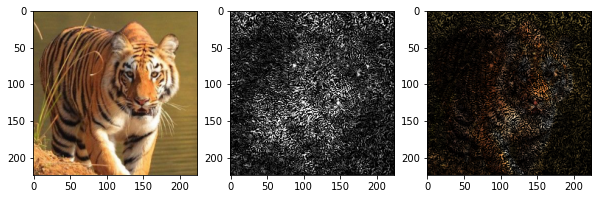

In [34]:
showGradients(imagePath, model)

### Integrated Gradients

In [35]:
def getModelName(model):
    return str(type(model)).split('.')[-1].split("'")[0]

In [47]:

def plotIntegratedGradients(imagePath, model):
    tensor = readImage(imagePath)
    prediction = th.argmax(model(tensor))
    baseline = -1.5 * torch.ones_like(tensor)
    inBtw = [baseline + a * (tensor - baseline)for a in np.linspace(0, 1, 100)]
    grads = [computeGradient(func, x, net=model, target = prediction) for x in inBtw]
    ig = (tensor - baseline) * torch.cat(grads[:-1]).mean(dim=0, keepdims=True)
    arr = toArray(tensor)
    ig_scaled = scaleGrad(ig)
    inp_grad_scaled = scaleGrad(grads[-1])
    figure, axis = plt.subplots(1, 4, figsize=(10, 10))

    axis[0].imshow(arr)
    axis[0].set_title(getModelName(model))
    axis[1].imshow(arr * inp_grad_scaled)
    axis[2].imshow(arr * ig_scaled)
    axis[3].imshow(ig_scaled.squeeze(2), cmap='gray')

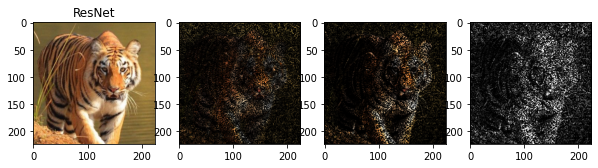

In [48]:
plotIntegratedGradients(imagePath, model)

In [ ]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

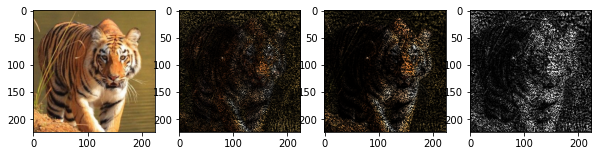

In [ ]:
plotIntegratedGradients(imagePath, vgg16)

In [78]:
modelsList = [
            models.resnet18(pretrained=True),
            models.alexnet(pretrained=True),
            models.squeezenet1_0(pretrained=True),
            models.vgg16(pretrained=True),
            models.densenet161(pretrained=True),
            models.googlenet(pretrained=True),
            models.mobilenet_v2(pretrained=True),
            models.mobilenet_v3_large(pretrained=True),
            models.mobilenet_v3_small(pretrained=True),
            models.resnext50_32x4d(pretrained=True),
            models.wide_resnet50_2(pretrained=True),
            models.mnasnet1_0(pretrained=True),
            models.regnet_x_3_2gf(pretrained=True),
            models.efficientnet_b7(pretrained=True),
]

  0%|          | 0/14 [00:00<?, ?it/s]

0 ResNet


  7%|▋         | 1/14 [00:03<00:43,  3.32s/it]

1 AlexNet


 14%|█▍        | 2/14 [00:05<00:30,  2.51s/it]

2 SqueezeNet


 21%|██▏       | 3/14 [00:06<00:23,  2.15s/it]

3 VGG


 29%|██▊       | 4/14 [00:16<00:49,  4.91s/it]

4 DenseNet


 36%|███▌      | 5/14 [00:32<01:21,  9.04s/it]

5 GoogLeNet


 43%|████▎     | 6/14 [00:36<00:58,  7.35s/it]

6 MobileNetV2


 50%|█████     | 7/14 [00:39<00:41,  5.90s/it]

7 MobileNetV3


 57%|█████▋    | 8/14 [00:42<00:30,  5.09s/it]

8 MobileNetV3


 64%|██████▍   | 9/14 [00:45<00:22,  4.40s/it]

9 ResNet


 71%|███████▏  | 10/14 [00:53<00:21,  5.48s/it]

10 ResNet


 79%|███████▊  | 11/14 [01:05<00:21,  7.31s/it]

11 MNASNet


 86%|████████▌ | 12/14 [01:07<00:11,  5.94s/it]

12 RegNet


 93%|█████████▎| 13/14 [01:18<00:07,  7.37s/it]

13 EfficientNet


100%|██████████| 14/14 [01:42<00:00,  7.34s/it]


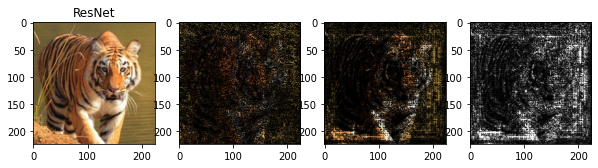

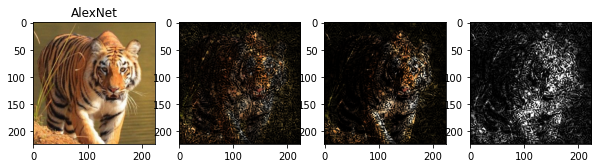

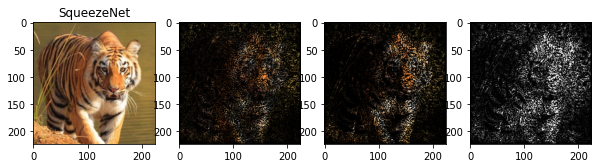

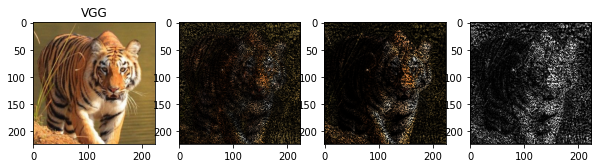

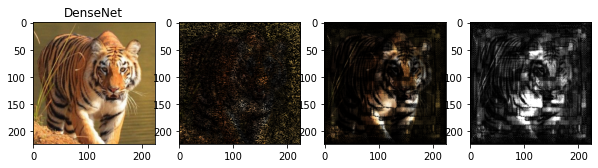

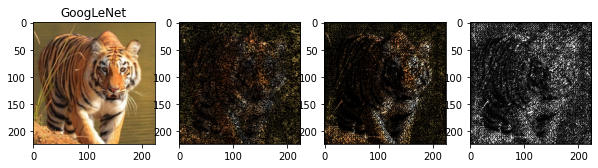

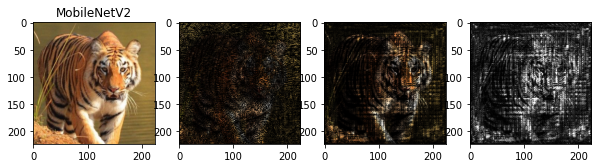

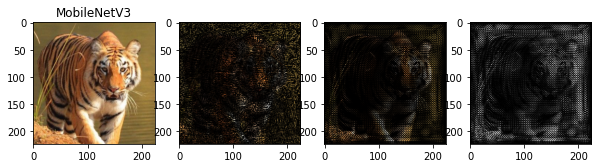

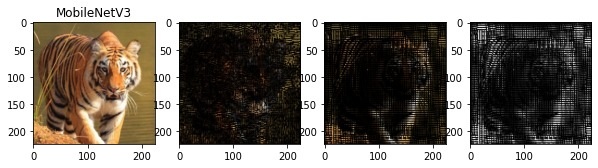

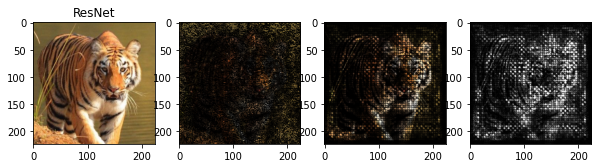

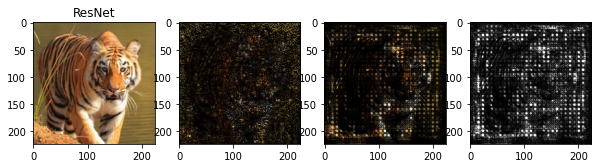

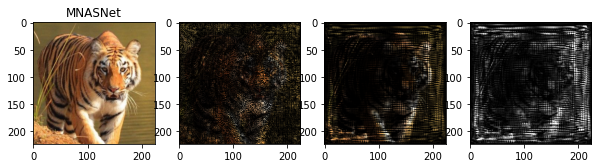

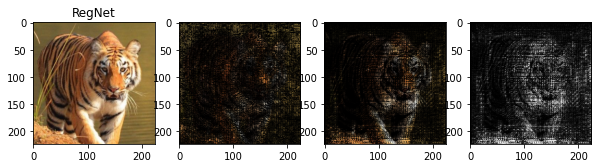

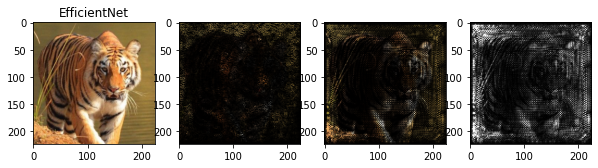

In [79]:
for model in tqdm(range(len(modelsList))):
    print(model, getModelName(modelsList[model]))
    plotIntegratedGradients(imagePath, modelsList[model].to(device))